# Method 3 - Best Ideas Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

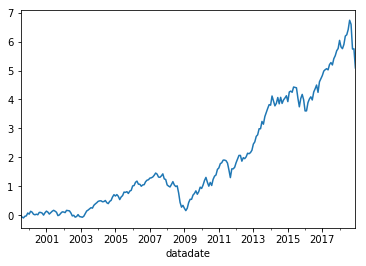

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.076814
2000-12-31    0.010032
2001-12-31    0.027528
2002-12-31   -0.144569
2003-12-31    0.497992
2004-12-31    0.194545
2005-12-31    0.088157
2006-12-31    0.196348
2007-12-31    0.004425
2008-12-31   -0.399846
2009-12-31    0.468131
2010-12-31    0.311873
2011-12-31    0.028399
2012-12-31    0.220396
2013-12-31    0.486401
2014-12-31    0.063532
2015-12-31   -0.027365
2016-12-31    0.146186
2017-12-31    0.182340
2018-12-31   -0.099079
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     644.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.58e-123
Time:                        13:33:55   Log-Likelihood:                 665.81
No. Observations:                 234   AIC:                            -1322.
Df Residuals:                     229   BIC:                            -1304.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.006      0.003       0.001       0.005
mktrf          0.9721      0.027     36.666      0.000       0.920       1.024
me             0.4430      0.031     14.366      0.000       0.382       0.504
ia             0.1709      0.047      3.646      0.000       0.079       0.263
roe            0.0286      0.040      0.713      0.476      -0.050       0.108
==============================================================================
Omnibus:                       27.571   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.520
Skew:                          -0.512   Prob(JB):                     8.02e-16
Kurtosis:                       5.466   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     748.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.39e-130
Time:                        13:33:55   Log-Likelihood:                 665.81
No. Observations:                 234   AIC:                            -1322.
Df Residuals:                     229   BIC:                            -1304.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.313      0.001       0.001       0.005
mktrf          0.9721      0.030     32.711      0.000       0.914       1.030
me             0.4430      0.058      7.689      0.000       0.330       0.556
ia             0.1709      0.086      1.978      0.048       0.002       0.340
roe            0.0286      0.036      0.790      0.429      -0.042       0.100
==============================================================================
Omnibus:                       27.571   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.520
Skew:                          -0.512   Prob(JB):                     8.02e-16
Kurtosis:                       5.466   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     1038.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.95e-145
Time:                        13:33:55   Log-Likelihood:                 665.81
No. Observations:                 234   AIC:                            -1322.
Df Residuals:                     229   BIC:                            -1304.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.622      0.000       0.001       0.004
mktrf          0.9721      0.027     36.238      0.000       0.920       1.025
me             0.4430      0.056      7.981      0.000       0.334       0.552
ia             0.1709      0.102      1.671      0.095      -0.030       0.371
roe            0.0286      0.037      0.780      0.435      -0.043       0.101
==============================================================================
Omnibus:                       27.571   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.520
Skew:                          -0.512   Prob(JB):                     8.02e-16
Kurtosis:                       5.466   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     474.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.73e-118
Time:                        13:33:55   Log-Likelihood:                 657.31
No. Observations:                 234   AIC:                            -1303.
Df Residuals:                     228   BIC:                            -1282.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.622      0.009       0.001       0.005
mktrf          0.9796      0.028     35.483      0.000       0.925       1.034
smb            0.4883      0.036     13.406      0.000       0.417       0.560
hml            0.0728      0.043      1.694      0.092      -0.012       0.157
rmw            0.0742      0.049      1.528      0.128      -0.021       0.170
cma            0.0776      0.062      1.258      0.210      -0.044       0.199
==============================================================================
Omnibus:                       22.729   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.646
Skew:                          -0.413   Prob(JB):                     8.25e-13
Kurtosis:                       5.242   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     489.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.66e-120
Time:                        13:33:55   Log-Likelihood:                 657.31
No. Observations:                 234   AIC:                            -1303.
Df Residuals:                     228   BIC:                            -1282.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.997      0.003       0.001       0.004
mktrf          0.9796      0.030     32.838      0.000       0.921       1.038
smb            0.4883      0.051      9.493      0.000       0.388       0.589
hml            0.0728      0.075      0.967      0.333      -0.075       0.220
rmw            0.0742      0.048      1.553      0.120      -0.019       0.168
cma            0.0776      0.078      0.994      0.320      -0.075       0.231
==============================================================================
Omnibus:                       22.729   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.646
Skew:                          -0.413   Prob(JB):                     8.25e-13
Kurtosis:                       5.242   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     588.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.66e-128
Time:                        13:33:55   Log-Likelihood:                 657.31
No. Observations:                 234   AIC:                            -1303.
Df Residuals:                     228   BIC:                            -1282.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.123      0.002       0.001       0.004
mktrf          0.9796      0.029     34.292      0.000       0.924       1.036
smb            0.4883      0.050      9.733      0.000       0.390       0.587
hml            0.0728      0.082      0.892      0.373      -0.087       0.233
rmw            0.0742      0.049      1.518      0.129      -0.022       0.170
cma            0.0776      0.079      0.986      0.324      -0.077       0.232
==============================================================================
Omnibus:                       22.729   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.646
Skew:                          -0.413   Prob(JB):                     8.25e-13
Kurtosis:                       5.242   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     536.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.78e-115
Time:                        13:33:55   Log-Likelihood:                 646.34
No. Observations:                 234   AIC:                            -1283.
Df Residuals:                     229   BIC:                            -1265.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.033      0.003       0.001       0.005
mktrf          0.9763      0.027     36.805      0.000       0.924       1.029
smb            0.4113      0.033     12.420      0.000       0.346       0.477
hml            0.2254      0.033      6.852      0.000       0.161       0.290
umd            0.0410      0.022      1.900      0.059      -0.002       0.084
==============================================================================
Omnibus:                       26.650   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.837
Skew:                          -0.419   Prob(JB):                     2.80e-18
Kurtosis:                       5.755   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     529.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.87e-114
Time:                        13:33:55   Log-Likelihood:                 646.34
No. Observations:                 234   AIC:                            -1283.
Df Residuals:                     229   BIC:                            -1265.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.983      0.003       0.001       0.005
mktrf          0.9763      0.035     28.115      0.000       0.908       1.044
smb            0.4113      0.051      7.995      0.000       0.310       0.512
hml            0.2254      0.075      2.991      0.003       0.078       0.373
umd            0.0410      0.038      1.084      0.279      -0.033       0.115
==============================================================================
Omnibus:                       26.650   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.837
Skew:                          -0.419   Prob(JB):                     2.80e-18
Kurtosis:                       5.755   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     653.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.35e-124
Time:                        13:33:55   Log-Likelihood:                 646.34
No. Observations:                 234   AIC:                            -1283.
Df Residuals:                     229   BIC:                            -1265.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.146      0.002       0.001       0.005
mktrf          0.9763      0.032     30.772      0.000       0.914       1.038
smb            0.4113      0.052      7.939      0.000       0.310       0.513
hml            0.2254      0.085      2.649      0.008       0.059       0.392
umd            0.0410      0.030      1.363      0.173      -0.018       0.100
==============================================================================
Omnibus:                       26.650   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.837
Skew:                          -0.419   Prob(JB):                     2.80e-18
Kurtosis:                       5.755   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     273.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.15e-58
Time:                        13:33:55   Log-Likelihood:                 323.98
No. Observations:                 120   AIC:                            -638.0
Df Residuals:                     115   BIC:                            -624.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.809      0.073      -0.000       0.006
mktrf          0.9799      0.043     22.881      0.000       0.895       1.065
me             0.4152      0.042      9.815      0.000       0.331       0.499
ia             0.2157      0.066      3.257      0.001       0.085       0.347
roe            0.0669      0.059      1.141      0.256      -0.049       0.183
==============================================================================
Omnibus:                        7.039   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                8.248
Skew:                          -0.354   Prob(JB):                       0.0162
Kurtosis:                       4.071   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     629.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.71e-77
Time:                        13:33:55   Log-Likelihood:                 323.98
No. Observations:                 120   AIC:                            -638.0
Df Residuals:                     115   BIC:                            -624.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.184      0.029       0.000       0.005
mktrf          0.9799      0.050     19.553      0.000       0.882       1.078
me             0.4152      0.057      7.288      0.000       0.304       0.527
ia             0.2157      0.090      2.394      0.017       0.039       0.392
roe            0.0669      0.062      1.072      0.284      -0.055       0.189
==============================================================================
Omnibus:                        7.039   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                8.248
Skew:                          -0.354   Prob(JB):                       0.0162
Kurtosis:                       4.071   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     1097.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-90
Time:                        13:33:55   Log-Likelihood:                 323.98
No. Observations:                 120   AIC:                            -638.0
Df Residuals:                     115   BIC:                            -624.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.674      0.007       0.001       0.005
mktrf          0.9799      0.047     20.840      0.000       0.888       1.072
me             0.4152      0.056      7.376      0.000       0.305       0.525
ia             0.2157      0.102      2.111      0.035       0.015       0.416
roe            0.0669      0.063      1.063      0.288      -0.056       0.190
==============================================================================
Omnibus:                        7.039   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                8.248
Skew:                          -0.354   Prob(JB):                       0.0162
Kurtosis:                       4.071   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     187.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.77e-53
Time:                        13:33:55   Log-Likelihood:                 316.11
No. Observations:                 120   AIC:                            -620.2
Df Residuals:                     114   BIC:                            -603.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.659      0.100      -0.001       0.006
mktrf          1.0027      0.048     20.706      0.000       0.907       1.099
smb            0.4823      0.055      8.794      0.000       0.374       0.591
hml            0.0473      0.067      0.703      0.483      -0.086       0.180
rmw            0.1321      0.079      1.667      0.098      -0.025       0.289
cma            0.1411      0.087      1.625      0.107      -0.031       0.313
==============================================================================
Omnibus:                        7.269   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                8.295
Skew:                          -0.381   Prob(JB):                       0.0158
Kurtosis:                       4.038   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     337.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.54e-66
Time:                        13:33:55   Log-Likelihood:                 316.11
No. Observations:                 120   AIC:                            -620.2
Df Residuals:                     114   BIC:                            -603.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.010      0.044    7.28e-05       0.006
mktrf          1.0027      0.062     16.210      0.000       0.881       1.124
smb            0.4823      0.069      7.023      0.000       0.348       0.617
hml            0.0473      0.121      0.392      0.695      -0.189       0.284
rmw            0.1321      0.110      1.200      0.230      -0.084       0.348
cma            0.1411      0.094      1.506      0.132      -0.043       0.325
==============================================================================
Omnibus:                        7.269   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                8.295
Skew:                          -0.381   Prob(JB):                       0.0158
Kurtosis:                       4.038   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     410.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.96e-71
Time:                        13:33:55   Log-Likelihood:                 316.11
No. Observations:                 120   AIC:                            -620.2
Df Residuals:                     114   BIC:                            -603.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.420      0.016       0.001       0.005
mktrf          1.0027      0.063     15.862      0.000       0.879       1.127
smb            0.4823      0.069      6.987      0.000       0.347       0.618
hml            0.0473      0.134      0.351      0.725      -0.216       0.311
rmw            0.1321      0.121      1.097      0.273      -0.104       0.368
cma            0.1411      0.092      1.539      0.124      -0.039       0.321
==============================================================================
Omnibus:                        7.269   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                8.295
Skew:                          -0.381   Prob(JB):                       0.0158
Kurtosis:                       4.038   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     206.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.62e-51
Time:                        13:33:55   Log-Likelihood:                 308.93
No. Observations:                 120   AIC:                            -607.9
Df Residuals:                     115   BIC:                            -593.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.332      0.021       0.001       0.008
mktrf          0.9590      0.043     22.423      0.000       0.874       1.044
smb            0.3869      0.049      7.946      0.000       0.290       0.483
hml            0.2543      0.049      5.215      0.000       0.158       0.351
umd            0.0300      0.030      0.998      0.320      -0.030       0.090
==============================================================================
Omnibus:                        7.223   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                8.176
Skew:                          -0.383   Prob(JB):                       0.0168
Kurtosis:                       4.025   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     281.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.25e-58
Time:                        13:33:55   Log-Likelihood:                 308.93
No. Observations:                 120   AIC:                            -607.9
Df Residuals:                     115   BIC:                            -593.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.001      2.885      0.004       0.001       0.007
mktrf          0.9590      0.054     17.905      0.000       0.854       1.064
smb            0.3869      0.055      7.044      0.000       0.279       0.495
hml            0.2543      0.090      2.824      0.005       0.078       0.431
umd            0.0300      0.046      0.646      0.518      -0.061       0.121
==============================================================================
Omnibus:                        7.223   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                8.176
Skew:                          -0.383   Prob(JB):                       0.0168
Kurtosis:                       4.025   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     350.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.96e-63
Time:                        13:33:55   Log-Likelihood:                 308.93
No. Observations:                 120   AIC:                            -607.9
Df Residuals:                     115   BIC:                            -593.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.001      3.674      0.000       0.002       0.006
mktrf          0.9590      0.047     20.403      0.000       0.867       1.051
smb            0.3869      0.053      7.285      0.000       0.283       0.491
hml            0.2543      0.099      2.571      0.010       0.060       0.448
umd            0.0300      0.037      0.808      0.419      -0.043       0.103
==============================================================================
Omnibus:                        7.223   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                8.176
Skew:                          -0.383   Prob(JB):                       0.0168
Kurtosis:                       4.025   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     592.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.94e-73
Time:                        13:33:56   Log-Likelihood:                 370.21
No. Observations:                 114   AIC:                            -730.4
Df Residuals:                     109   BIC:                            -716.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.563      0.001       0.002       0.005
mktrf          0.9612      0.028     33.987      0.000       0.905       1.017
me             0.5110      0.044     11.704      0.000       0.424       0.598
ia            -0.0608      0.061     -1.004      0.318      -0.181       0.059
roe           -0.1911      0.053     -3.591      0.000      -0.297      -0.086
==============================================================================
Omnibus:                        7.162   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                8.721
Skew:                          -0.349   Prob(JB):                       0.0128
Kurtosis:                       4.161   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1914.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.78e-100
Time:                        13:33:56   Log-Likelihood:                 370.21
No. Observations:                 114   AIC:                            -730.4
Df Residuals:                     109   BIC:                            -716.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.492      0.000       0.001       0.005
mktrf          0.9612      0.020     48.672      0.000       0.922       1.000
me             0.5110      0.039     13.030      0.000       0.434       0.588
ia            -0.0608      0.076     -0.802      0.422      -0.209       0.088
roe           -0.1911      0.054     -3.530      0.000      -0.297      -0.085
==============================================================================
Omnibus:                        7.162   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                8.721
Skew:                          -0.349   Prob(JB):                       0.0128
Kurtosis:                       4.161   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     3643.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.96e-115
Time:                        13:33:56   Log-Likelihood:                 370.21
No. Observations:                 114   AIC:                            -730.4
Df Residuals:                     109   BIC:                            -716.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.060      0.002       0.001       0.006
mktrf          0.9612      0.016     58.651      0.000       0.929       0.993
me             0.5110      0.036     14.322      0.000       0.441       0.581
ia            -0.0608      0.082     -0.744      0.457      -0.221       0.099
roe           -0.1911      0.054     -3.570      0.000      -0.296      -0.086
==============================================================================
Omnibus:                        7.162   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                8.721
Skew:                          -0.349   Prob(JB):                       0.0128
Kurtosis:                       4.161   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     570.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.86e-76
Time:                        13:33:56   Log-Likelihood:                 380.80
No. Observations:                 114   AIC:                            -749.6
Df Residuals:                     108   BIC:                            -733.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.822      0.006       0.001       0.004
mktrf          0.9776      0.025     39.594      0.000       0.929       1.027
smb            0.4824      0.040     12.034      0.000       0.403       0.562
hml           -0.0302      0.051     -0.591      0.555      -0.132       0.071
rmw           -0.3035      0.063     -4.849      0.000      -0.428      -0.179
cma           -0.0475      0.079     -0.598      0.551      -0.205       0.110
==============================================================================
Omnibus:                        3.201   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                3.433
Skew:                          -0.025   Prob(JB):                        0.180
Kurtosis:                       3.849   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     1339.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.07e-95
Time:                        13:33:56   Log-Likelihood:                 380.80
No. Observations:                 114   AIC:                            -749.6
Df Residuals:                     108   BIC:                            -733.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.411      0.016       0.000       0.005
mktrf          0.9776      0.015     67.137      0.000       0.949       1.006
smb            0.4824      0.049      9.920      0.000       0.387       0.578
hml           -0.0302      0.054     -0.557      0.578      -0.137       0.076
rmw           -0.3035      0.070     -4.353      0.000      -0.440      -0.167
cma           -0.0475      0.083     -0.571      0.568      -0.211       0.116
==============================================================================
Omnibus:                        3.201   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                3.433
Skew:                          -0.025   Prob(JB):                        0.180
Kurtosis:                       3.849   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     2061.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.20e-105
Time:                        13:33:56   Log-Likelihood:                 380.80
No. Observations:                 114   AIC:                            -749.6
Df Residuals:                     108   BIC:                            -733.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.987      0.047    3.41e-05       0.005
mktrf          0.9776      0.012     79.215      0.000       0.953       1.002
smb            0.4824      0.046     10.568      0.000       0.393       0.572
hml           -0.0302      0.049     -0.619      0.536      -0.126       0.066
rmw           -0.3035      0.075     -4.028      0.000      -0.451      -0.156
cma           -0.0475      0.077     -0.615      0.538      -0.199       0.104
==============================================================================
Omnibus:                        3.201   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                3.433
Skew:                          -0.025   Prob(JB):                        0.180
Kurtosis:                       3.849   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     586.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.06e-72
Time:                        13:33:56   Log-Likelihood:                 369.61
No. Observations:                 114   AIC:                            -729.2
Df Residuals:                     109   BIC:                            -715.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.601      0.112      -0.000       0.003
mktrf          1.0114      0.027     37.541      0.000       0.958       1.065
smb            0.5433      0.042     12.932      0.000       0.460       0.627
hml            0.0626      0.043      1.446      0.151      -0.023       0.148
umd            0.0533      0.033      1.634      0.105      -0.011       0.118
==============================================================================
Omnibus:                        4.356   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                3.866
Skew:                          -0.336   Prob(JB):                        0.145
Kurtosis:                       3.602   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     752.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.29e-78
Time:                        13:33:56   Log-Likelihood:                 369.61
No. Observations:                 114   AIC:                            -729.2
Df Residuals:                     109   BIC:                            -715.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.483      0.138      -0.000       0.004
mktrf          1.0114      0.024     42.816      0.000       0.965       1.058
smb            0.5433      0.048     11.300      0.000       0.449       0.638
hml            0.0626      0.051      1.224      0.221      -0.038       0.163
umd            0.0533      0.025      2.108      0.035       0.004       0.103
==============================================================================
Omnibus:                        4.356   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                3.866
Skew:                          -0.336   Prob(JB):                        0.145
Kurtosis:                       3.602   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1081.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.07e-86
Time:                        13:33:56   Log-Likelihood:                 369.61
No. Observations:                 114   AIC:                            -729.2
Df Residuals:                     109   BIC:                            -715.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.271      0.204      -0.001       0.004
mktrf          1.0114      0.021     47.764      0.000       0.970       1.053
smb            0.5433      0.038     14.203      0.000       0.468       0.618
hml            0.0626      0.047      1.337      0.181      -0.029       0.154
umd            0.0533      0.026      2.027      0.043       0.002       0.105
==============================================================================
Omnibus:                        4.356   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                3.866
Skew:                          -0.336   Prob(JB):                        0.145
Kurtosis:                       3.602   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""